In [3]:
import pandas as pd
import sys
import numpy as np
sys.path.append('../utils')
sys.path.append('..')
from pathlib import Path
import umap
import hiplot as hip
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from EDA_utils import*

# Importing data

In [4]:
data_folder_path = Path("../Datasets/Raw/Twi_2020")
new_format_data_path = Path("../Datasets/Raw/Twibot-20-new-format")

In [5]:
neighbor_data_file = "edge.csv"
label_data_file = "label.csv"
profile_data_file = "node.part0.parquet"
# tweets_data_file = "Twi20_tweets.parquet"
split_data_file = "split.csv"

In [6]:
neighbor_df = pd.read_csv(new_format_data_path/neighbor_data_file)
label_df = pd.read_csv(new_format_data_path/label_data_file)
profile_df = pd.read_parquet(new_format_data_path/profile_data_file)
split_df = pd.read_csv(new_format_data_path/split_data_file)

In [7]:
preprocessed_profile_df = (
    profile_df
    .pipe(
        profile_data_preprocessing,
        label_df=label_df, split_df=split_df, neighbor_df=neighbor_df
      )
  )


c:\Users\maria\OneDrive\Documentos\Github\MO436---Twitter-bot-detection\3_EDA\../utils\EDA_utils.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  created_at=lambda d: pd.to_datetime(d["created_at"]),  # Convert created_at to datetime


In [8]:
preprocessed_profile_df.followers_follow_proportion

0         22181.465056
1             0.000000
2          1605.973461
3            68.233062
4            20.593477
              ...     
229575        0.080617
229576        1.129729
229577        0.164541
229578        0.247309
229579        0.368224
Name: followers_follow_proportion, Length: 229580, dtype: float64

# Graph Feature Engineering

In [9]:
# def feature_selection_pipeline(features_df):
#   #use recursive shap error contribution
#   return

In [10]:
# Define the number of dimensions for TruncatedSVD
ndims = 10

# Feature engineering pipeline
# Create a ColumnTransformer that applies different transformations to different columns
feature_eng_pipeline = ColumnTransformer(
    [
        # Apply CountVectorizer to the 'followed_string' column
        ("vectorizer_followed", CountVectorizer(), "followed_string"),
        # Apply CountVectorizer to the 'follow_string' column
        ("vectorizer_follow", CountVectorizer(), "follow_string"),
        # Apply CountVectorizer to the 'friend_string' column
        ("vectorizer_friend", CountVectorizer(), "friend_string")
    ]
)

In [11]:
# Add TruncatedSVD to the pipeline to reduce dimensionality to 30 components
pipeline = make_pipeline(feature_eng_pipeline, TruncatedSVD(n_components=3 * ndims))

# Uncomment the following lines if you want to change the TruncatedSVD dimensions or add more steps to the pipeline:

# feature_eng_pipeline = make_pipeline(feature_eng_pipeline, TruncatedSVD(50))
# inference_pipeline = make_pipeline(feature_eng_pipeline, SGDClassifier(loss="log"))

In [12]:
# Define masks to split the data into training, testing, support, and validation sets
train_mask = lambda d: d["split"] == "train"
test_mask = lambda d: d["split"] == "test"
support_mask = lambda d: d["split"] == "support"
val_mask = lambda d: d["split"] == "val"

# Define the target variable
target = "label"

In [13]:
# Fit the feature engineering pipeline using the training and support data
pipeline.fit(preprocessed_profile_df[lambda d: (train_mask(d) | support_mask(d))])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('vectorizer_followed',
                                                  CountVectorizer(),
                                                  'followed_string'),
                                                 ('vectorizer_follow',
                                                  CountVectorizer(),
                                                  'follow_string'),
                                                 ('vectorizer_friend',
                                                  CountVectorizer(),
                                                  'friend_string')])),
                ('truncatedsvd', TruncatedSVD(n_components=30))])

In [14]:
#X = pipeline.transform(preprocessed_profile_df)
#y = preprocessed_profile_df[target]

In [15]:
# Transform the entire DataFrame to get the graph embeddings
graph_embs = pipeline.transform(preprocessed_profile_df)

In [16]:
# Ensure graph_embs is a dense array
if hasattr(graph_embs, "toarray"):
    graph_embs = graph_embs.toarray()

# Generate column names for the embeddings
embs_names = (
    [f"followed_embs{i}" for i in range(ndims)] +  # 10 Columns for followed embeddings
    [f"follow_embs{i}" for i in range(ndims)] +    # 10 Columns for follow embeddings
    [f"friend_embs{i}" for i in range(ndims)]      # 10 Columns for friend embeddings
)

In [17]:
# Check if the dimensions match (should be 30 columns)
assert graph_embs.shape[1] == len(embs_names), "Mismatch between embedding dimensions and names."

# Add the embeddings to the preprocessed profile DataFrame
graph_embs_df = pd.DataFrame(graph_embs, columns=embs_names, index=preprocessed_profile_df.index)
preprocessed_profile_df = pd.concat([preprocessed_profile_df, graph_embs_df], axis=1)

# Delete the graph embeddings variable to free up memory
del graph_embs, graph_embs_df

In [18]:
#y_train = preprocessed_profile_df[train_mask][target]

#X_val = feature_eng_pipeline.transform(preprocessed_profile_df[val_mask])
#y_val = preprocessed_profile_df[val_mask][target]

#X_test = feature_eng_pipeline.transform(preprocessed_profile_df[test_mask])
# y_test = preprocessed_profile_df[test_mask][target]

In [19]:
# Dstribution of the split values
# preprocessed_profile_df.split.value_counts()

# Include only rows where split is 'support'
# preprocessed_profile_df[lambda d: d.split == "support"]

In [20]:
#preprocessed_profile_df.to_parquet(data_folder_path.parent/"preprocessed_features_with_graph_embeddings.parquet")

In [21]:
df = preprocessed_profile_df
df.head()

,created_at,description,entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics,...,friend_embs0,friend_embs1,friend_embs2,friend_embs3,friend_embs4,friend_embs5,friend_embs6,friend_embs7,friend_embs8,friend_embs9
0,2008-11-18 10:27:25+00:00,"VERY QUOTATIOUS, I PERFORM RANDOM ACTS OF SHAQ...",{'url': {'urls': [{'url': 'https://t.co/7hsiK8...,u17461978,"Orlando, FL",SHAQ,NaN,http://pbs.twimg.com/profile_images/1673907275...,False,"{'followers_count': 15349596.0, 'following_cou...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-08-23 07:35:11+00:00,,{'description': {'urls': []}},u1297437077403885568,,Jennifer Fishpaw,NaN,http://pbs.twimg.com/profile_images/1297437406...,False,"{'followers_count': 0.0, 'following_count': 44...",...,-0.138393,0.407364,-0.107328,-0.009497,-0.099696,-0.142451,-0.196142,-0.059257,0.113511,0.035617
2,2008-11-27 18:47:32+00:00,Owner @ Parscale Strategy. Senior Advisor Digi...,{'url': {'urls': [{'url': 'https://t.co/GooZcY...,u17685258,Florida,Brad Parscale,NaN,http://pbs.twimg.com/profile_images/1295453225...,False,"{'followers_count': 762839.0, 'following_count...",...,-0.089939,0.075174,-0.050414,0.031960,0.056451,-0.055387,0.129104,-0.022095,-0.122092,0.104968
3,2008-08-06 15:12:10+00:00,Bringing you the important stuff like breaking...,{'url': {'urls': [{'url': 'https://t.co/RtP9QY...,u15750898,"Tampa, FL",FOX 13 Tampa Bay,NaN,http://pbs.twimg.com/profile_images/1293193013...,False,"{'followers_count': 327587.0, 'following_count...",...,0.005909,0.003815,-0.007906,-0.001014,0.009245,0.005395,0.000896,0.010956,0.000709,0.009604
4,2013-08-10 03:25:35+00:00,MOTIVATION 3 OUT NOW 🔥 Singles: ‘Lil Shawdy’ &...,{'url': {'urls': [{'url': 'https://t.co/5cY8GW...,u1659167666,"Jacksonville Beach, FL",Vonte The Plug 🎤🔌,NaN,http://pbs.twimg.com/profile_images/1181662400...,False,"{'followers_count': 13324.0, 'following_count'...",...,0.004209,0.002042,-0.009367,-0.007924,-0.000699,0.002722,0.008432,-0.007490,0.003642,-0.003016


# Visualize the data with UMAP

In [22]:
df = preprocessed_profile_df
df.head()

,created_at,description,entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics,...,friend_embs0,friend_embs1,friend_embs2,friend_embs3,friend_embs4,friend_embs5,friend_embs6,friend_embs7,friend_embs8,friend_embs9
0,2008-11-18 10:27:25+00:00,"VERY QUOTATIOUS, I PERFORM RANDOM ACTS OF SHAQ...",{'url': {'urls': [{'url': 'https://t.co/7hsiK8...,u17461978,"Orlando, FL",SHAQ,NaN,http://pbs.twimg.com/profile_images/1673907275...,False,"{'followers_count': 15349596.0, 'following_cou...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-08-23 07:35:11+00:00,,{'description': {'urls': []}},u1297437077403885568,,Jennifer Fishpaw,NaN,http://pbs.twimg.com/profile_images/1297437406...,False,"{'followers_count': 0.0, 'following_count': 44...",...,-0.138393,0.407364,-0.107328,-0.009497,-0.099696,-0.142451,-0.196142,-0.059257,0.113511,0.035617
2,2008-11-27 18:47:32+00:00,Owner @ Parscale Strategy. Senior Advisor Digi...,{'url': {'urls': [{'url': 'https://t.co/GooZcY...,u17685258,Florida,Brad Parscale,NaN,http://pbs.twimg.com/profile_images/1295453225...,False,"{'followers_count': 762839.0, 'following_count...",...,-0.089939,0.075174,-0.050414,0.031960,0.056451,-0.055387,0.129104,-0.022095,-0.122092,0.104968
3,2008-08-06 15:12:10+00:00,Bringing you the important stuff like breaking...,{'url': {'urls': [{'url': 'https://t.co/RtP9QY...,u15750898,"Tampa, FL",FOX 13 Tampa Bay,NaN,http://pbs.twimg.com/profile_images/1293193013...,False,"{'followers_count': 327587.0, 'following_count...",...,0.005909,0.003815,-0.007906,-0.001014,0.009245,0.005395,0.000896,0.010956,0.000709,0.009604
4,2013-08-10 03:25:35+00:00,MOTIVATION 3 OUT NOW 🔥 Singles: ‘Lil Shawdy’ &...,{'url': {'urls': [{'url': 'https://t.co/5cY8GW...,u1659167666,"Jacksonville Beach, FL",Vonte The Plug 🎤🔌,NaN,http://pbs.twimg.com/profile_images/1181662400...,False,"{'followers_count': 13324.0, 'following_count'...",...,0.004209,0.002042,-0.009367,-0.007924,-0.000699,0.002722,0.008432,-0.007490,0.003642,-0.003016


In [23]:
# embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
embedding = umap.UMAP(n_neighbors=15, random_state=42, n_jobs=1)

sample_df = df.sample(frac=0.3,random_state=0)
# fit the data (The index of transformed data corresponds to the index of the original data)
embs = embedding.fit_transform(sample_df[embs_names])

sample_df[["UMAP1","UMAP2"]] = embs

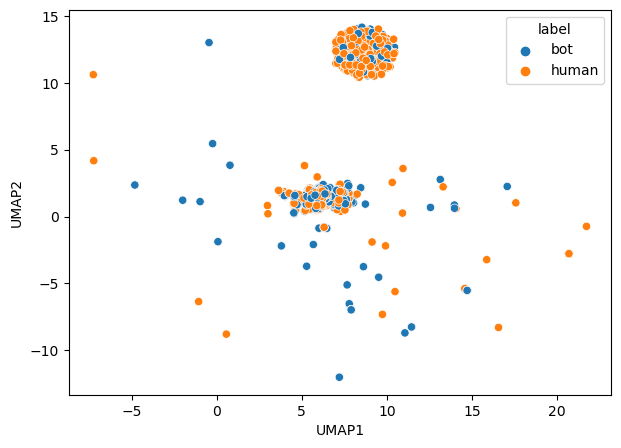

In [24]:
# visualize the embedding
plt.figure(figsize=(7, 5))

sns.scatterplot(data=sample_df, x="UMAP1", y="UMAP2", hue = "label")
plt.show()

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

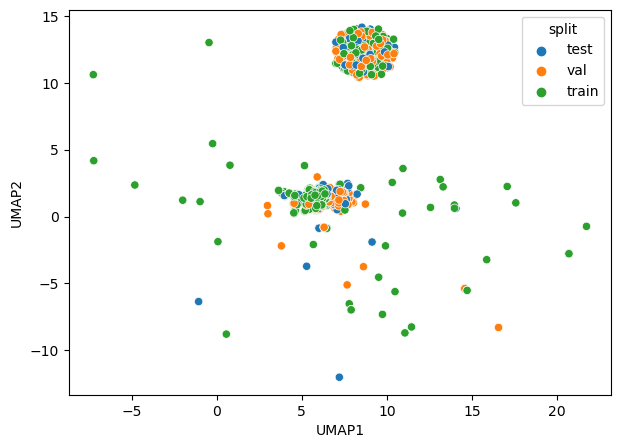

In [25]:
# visualize the embedding
plt.figure(figsize=(7, 5))

sns.scatterplot(data=sample_df[lambda d: d.split != "support"], x="UMAP1", y="UMAP2", hue = "split")

In [27]:
sample_df.dtypes

created_at      datetime64[ns, UTC]
description                  object
entities                     object
id                           object
location                     object
                       ...         
friend_embs7                float64
friend_embs8                float64
friend_embs9                float64
UMAP1                       float32
UMAP2                       float32
Length: 62, dtype: object

# Using HiPlot to visualize data

https://ai.meta.com/blog/hiplot-high-dimensional-interactive-plots-made-easy/

In [ ]:
def visualize_with_hiplot(df):
    """
    Visualizes a Pandas DataFrame using HiPlot.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data to visualize.
    
    Returns:
    - Displays an interactive HiPlot visualization.
    """
    # Convert the DataFrame to a HiPlot experiment
    data = df.to_dict(orient='records')
    exp = hip.Experiment.from_iterable(data)
    
    # Display the HiPlot visualization
    exp.display()